In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
import numpy as np
import casadi
from direct_collocation import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [3]:
# Set up a visualization

import matplotlib.pyplot as plt
import matplotlib as mpl


# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True


In [4]:
'''# We construct the model as a set of differential-algebraic equations (DAE)
car = casadi.DaeBuilder()
# Parameters
n = 5 # states
m = 2 # controls
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

a_limit = np.array([-5, 1])
# Steering limit max/min in radians
delta_f_limit = np.array([-np.pi/4, np.pi/4])

# Constants
lr = 2.10 # distance from CG to back wheel in meters
lf = 2.67
# Source, page 40: https://www.diva-portal.org/smash/get/diva2:860675/FULLTEXT01.pdf

# States
z    = car.add_x('z', 5)
x    = z[0]
y    = z[1]
v    = z[2]
psi  = z[3]
beta = z[4]

STATE_NAMES = ['x', 'y', 'v', 'psi', 'beta']
 
# Controls
u       = car.add_u('u',2)       # acceleration
a       = u[0]
delta_f = u[1] # front steering angle
CONTROL_NAMES = ['a', 'delta_f']

# Define ODEs
xdot = v*casadi.cos(psi + beta)
ydot = v*casadi.sin(psi + beta)
vdot = a
psidot = v/lr*casadi.sin(beta)
betadot = v/(lf + lr)*casadi.tan(delta_f) - v/lr*casadi.sin(beta)

zdot = casadi.vertcat(xdot, ydot, vdot, psidot, betadot)
car.add_ode('zdot', zdot)
'''
car = KinematicBicycleCar(N = 30, step = 0.01)

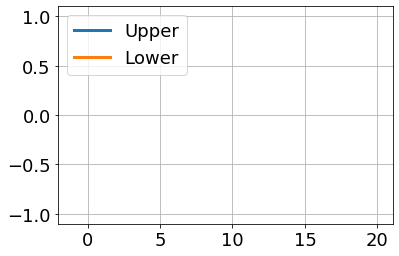

In [5]:
# Acceleration bounds from 
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Sec3

# TODO: Fix lower/upper bounds to sample from functions for x, y.
def lowerbounds(varname, i, k):
    if varname == 'z':
        limits = [-1.0,
                  -1.0,
                  0.0,
                  -np.pi/4,
                  -np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [-1.70, -np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: lowerbounds doesn't understand variable named "+varname)
        return -np.inf
    
def upperbounds(varname, i, k):
    if varname == 'z':
        limits = [20.0,
                  1.0,
                  20.0,
                  np.pi/4,
                  np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [0.84, np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: upperbounds doesn't understand variable named "+varname)
        return np.inf

    
upper_bound = np.empty((250,2))
lower_bound = np.empty((250,2))
for k in range(250):
    upper_bound[k,0] = upperbounds('z',0,k)
    upper_bound[k,1] = upperbounds('z',1,k)
    
    lower_bound[k,0] = lowerbounds('z',0,k)
    lower_bound[k,1] = lowerbounds('z',1,k)
    
plt.plot(upper_bound[:,0], upper_bound[:,1], label="Upper")
plt.plot(lower_bound[:,0], lower_bound[:,1], label="Lower")
plt.legend()

In [6]:

        
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost
cost = (car.dae.x[0][2]-5)**2

In [7]:
    
mpcprob = MpcProblem(car.dae,         # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     lowerbounds, # given name of state/control variable, return lower bound
                     upperbounds, # given name of state/control variable, return upper bound
                     N    = 30,   # MPC horizon (steps)
                     step = 0.05, # Time step (seconds)
                     )
xk = ic
uk = [0.0,0.0]

n_runs = 20
x_plan = np.empty((mpcprob.n,n_runs+1))
u_plan = np.empty((mpcprob.m,n_runs))
x_true = np.empty((mpcprob.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(xk)
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(xk, uk)ue
    xk = x_tr[:,k+1]
    
    # hack, test changing cost
    if k == n_runs//2:
        mpcprob.set_cost(car.dae.x[0][2]**2)

print(x_plan)
print(u_plan)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  8.0485733e-04 1.02e-10 1.32e-06  -8.6 1.32e-02  -4.0 1.00e+00 1.00e+00h  1
  23  8.0478173e-04 4.97e-05 7.05e-08  -8.6 5.31e-02    -  1.00e+00 9.54e-01h  1
  24  8.0478422e-04 5.68e-06 8.96e-08  -8.6 1.57e-02    -  1.00e+00 1.00e+00h  1
  25  8.0478422e-04 5.96e-06 3.12e-08  -8.6 9.95e-03    -  1.00e+00 1.00e+00h  1
  26  8.0478422e-04 5.01e-10 2.69e-09  -8.6 8.07e-05  -4.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   8.0478422174372810e-04    8.0478422174372810e-04
Dual infeasibility......:   2.6900197443745334e-09    2.6900197443745334e-09
Constraint violation....:   5.0056053399472056e-10    5.0056053399472056e-10
Complementarity.........:   2.5059187682211440e-09    2.5059187682211440e-09
Overall NLP error.......:   2.6900197443745334e-09    2.6900197443745334e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations        

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  14  4.7680755e-02 8.74e-04 3.62e-02  -1.7 1.48e+00    -  8.90e-01 1.00e+00f  1
  15  5.4161402e-03 3.40e-05 1.09e-03  -2.5 7.47e-01    -  1.00e+00 1.00e+00h  1
  16  1.0072649e-03 8.40e-06 5.10e-04  -3.8 2.74e-01    -  9.23e-01 1.00e+00h  1
  17  8.2707514e-05 2.27e-07 2.81e-04  -5.7 2.29e-01    -  7.52e-01 1.00e+00h  1
  18  2.5055360e-06 2.78e-07 2.39e-05  -5.7 1.34e-01    -  9.47e-01 1.00e+00h  1
  19  4.0653001e-08 5.80e-06 2.75e-09  -5.7 6.87e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2892195e-10 9.68e-10 9.56e-08  -8.6 3.43e-02    -  9.81e-01 1.00e+00h  1
  21  7.7017523e-10 3.06e-12 1.06e-07  -8.6 1.06e-03  -4.0 1.00e+00 1.00e+00h  1
  22  7.6395394e-10 1.83e-14 1.05e-07  -8.6 4.90e-05  -2.7 1.00e+00 1.00e+00h  1
  23  5.3303951e-10 4.05e-05 2.24e-11  -8.6 4.55e-02    -  1.00e+00 1.00e+00h  1
  24  5.3303952e-10 5.71e-07 1.21e-13  -8.6 3.94e-03    -  1.00e+00 1.00e+00h  1
  25  5.3303952e-10 6.03e-12

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5691071e+00 1.04e+01 5.13e+00  -1.0 5.47e+00    -  8.25e-02 2.80e-01f  1
  11  1.7473127e+01 4.04e-03 1.58e+00  -1.0 4.11e+00    -  6.04e-01 1.00e+00f  1
  12  1.7790650e+01 2.47e-04 9.09e-02  -1.0 1.62e-01    -  1.00e+00 1.00e+00f  1
  13  1.7287082e+01 4.60e-05 1.52e-02  -2.5 2.24e-01    -  9.09e-01 8.40e-01f  1
  14  1.7162171e+01 1.84e-06 6.89e-03  -3.8 8.78e-01    -  6.40e-01 9.47e-01f  1
  15  1.7153586e+01 1.96e-06 2.64e-03  -3.8 7.53e-01    -  7.10e-01 1.00e+00h  1
  16  1.7152440e+01 1.33e-06 1.97e-09  -3.8 2.45e-01    -  1.00e+00 1.00e+00h  1
  17  1.7148007e+01 3.64e-08 9.85e-09  -5.7 2.42e-02    -  1.00e+00 1.00e+00h  1
  18  1.7147949e+01 3.14e-14 6.64e-06  -8.6 6.64e-04  -2.0 1.00e+00 1.00e+00h  1
  19  1.7147949e+01 2.26e-14 1.89e-07  -8.6 8.86e-07  -0.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.7147949e+01 1.74e-14

  19  1.5508292e+01 2.71e-14 1.32e-09  -8.6 1.18e-06  -3.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   1.5508292210135034e+01    1.5508292210135034e+01
Dual infeasibility......:   1.3158125989800061e-09    1.3158125989800061e-09
Constraint violation....:   2.7117197376469448e-14    2.7117197376469448e-14
Complementarity.........:   2.5059036081217987e-09    2.5059036081217987e-09
Overall NLP error.......:   2.5059036081217987e-09    2.5059036081217987e-09


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w

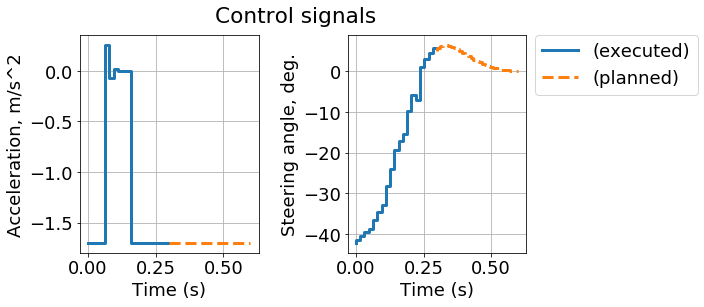

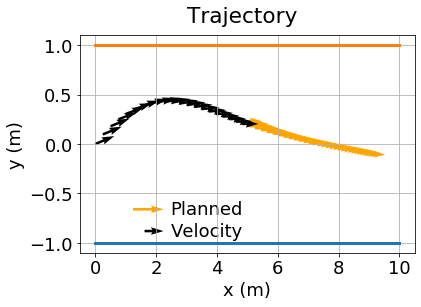

In [9]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.plot([0.0,10.0], [-1,-1]) # Road boundary (lower)
x_ax.plot([0.0,10.0], [1,1]) # (upper)
plt.show()